In [1]:
import pandas as pd
import pyarrow.parquet as pq
import psutil
import matplotlib.pyplot as plt
import gc

In [2]:
def get_memory_usage():
    process = psutil.Process()
    mem_info = process.memory_info()
    return mem_info.rss / (1024 ** 3)  # Return memory usage in GB

print(f"Initial memory usage: {get_memory_usage():.2f} GB")

y_2023 = pq.read_table('./raw_data/y_2023.parquet').to_pandas()

print(f"memory usage after read: {get_memory_usage():.2f} GB")

Initial memory usage: 0.19 GB
memory usage after read: 4.81 GB


In [3]:
y_2023.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38310226 entries, 0 to 38310225
Data columns (total 20 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee         

In [4]:
y_2023.RatecodeID.value_counts()

RatecodeID
1.0     34891490
2.0      1473727
5.0       217163
99.0      213480
3.0       127504
4.0        77445
6.0           61
Name: count, dtype: int64

Rate codes 1 - 6 are designated by the TLC as standard/airport/negotiated/group rates, but not 99. Unsure what this code represents. What can we determine about trips with rate code 99?

In [5]:
# % of ratecode 99 rides with no tip
100 * len(y_2023.loc[(y_2023.RatecodeID == 99) & (y_2023.tip_amount == 0)]) / len(y_2023.loc[y_2023.RatecodeID == 99])
# 99.95 %

99.95268877646618

In [6]:
y_2023.groupby(['RatecodeID']).trip_distance.mean()

RatecodeID
1.0      2.817361
2.0     17.381986
3.0     16.625427
4.0     23.323413
5.0      6.653452
6.0      1.765246
99.0    14.859373
Name: trip_distance, dtype: float64

In [7]:
y_2023.groupby(['RatecodeID']).fare_amount.mean()

RatecodeID
1.0      16.566456
2.0      67.557451
3.0      83.374685
4.0     105.376040
5.0      69.543095
6.0      47.456230
99.0     33.358036
Name: fare_amount, dtype: float64

Unclear what rate code 99 refers to (maybe a miscellaneous designation). We'll leave the corresponding records as they appear to be valid data.

Next: check for null values.

In [8]:
y_2023.isna().sum()

VendorID                        0
tpep_pickup_datetime            0
tpep_dropoff_datetime           0
passenger_count           1309356
trip_distance                   0
RatecodeID                1309356
store_and_fwd_flag        1309356
PULocationID                    0
DOLocationID                    0
payment_type                    0
fare_amount                     0
extra                           0
mta_tax                         0
tip_amount                      0
tolls_amount                    0
improvement_surcharge           0
total_amount                    0
congestion_surcharge      1309356
airport_fee              35315203
Airport_fee               4304379
dtype: int64

In [9]:
y_2023.loc[y_2023.passenger_count.isna()].head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,Airport_fee
2995023,1,2023-01-01 00:02:40,2023-01-01 00:30:36,NaN,0.00,NaN,None,142,79,0,20.13,0.0,0.5,0.00,0.0,1.0,24.13,NaN,NaN,NaN
2995024,1,2023-01-01 00:57:48,2023-01-01 01:12:34,NaN,0.00,NaN,None,237,263,0,12.00,1.0,0.5,2.55,0.0,1.0,21.55,NaN,NaN,NaN
2995025,2,2023-01-01 00:55:37,2023-01-01 01:00:41,NaN,0.86,NaN,None,24,41,0,12.80,0.0,0.5,2.14,0.0,1.0,16.44,NaN,NaN,NaN
2995026,2,2023-01-01 00:43:47,2023-01-01 00:56:12,NaN,5.36,NaN,None,88,229,0,24.51,0.0,0.5,4.28,0.0,1.0,32.79,NaN,NaN,NaN
2995027,2,2023-01-01 00:34:00,2023-01-01 00:51:00,NaN,6.03,NaN,None,232,263,0,32.30,0.0,0.5,7.26,0.0,1.0,43.56,NaN,NaN,NaN


Remove some of the bad data:
- non-2023 dates
- trips with distance 0 or over 100 miles

In [10]:
bad_dates = (y_2023.tpep_pickup_datetime < pd.Timestamp('2023-01-01')) | (y_2023.tpep_pickup_datetime > pd.Timestamp('2024-01-01')) | (y_2023.tpep_dropoff_datetime < pd.Timestamp('2023-01-01')) | (y_2023.tpep_dropoff_datetime > pd.Timestamp('2024-01-01'))
bad_dist = (y_2023.trip_distance == 0) | (y_2023.trip_distance > 100)

print(f"memory usage before drop: {get_memory_usage():.2f} GB")

y_2023 = y_2023.drop(y_2023[bad_dates | bad_dist].index)

print(f"memory usage after drop: {get_memory_usage():.2f} GB")

gc.collect()

print(f"memory usage after garbage collection: {get_memory_usage():.2f} GB")


memory usage before drop: 4.37 GB
memory usage after drop: 3.86 GB
memory usage after garbage collection: 2.22 GB


The missing data appears to correspond to the same records other than airport fees. Later we'll replace null values for passengers and rate codes with the column mode. We'll remove the store and forward flag, congestion surcharge, and airport fee columns.

Next: add features for trip duration, day of pickup, and hour of pickup.

In [11]:
y_2023['duration'] = ((y_2023.tpep_dropoff_datetime - y_2023.tpep_pickup_datetime) / pd.Timedelta(minutes=1)).round(2)
y_2023['day'] = y_2023.tpep_pickup_datetime.dt.day_name()
y_2023['hour'] = y_2023.tpep_pickup_datetime.dt.hour
gc.collect()

0

In [12]:
y_2023.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,Airport_fee,duration,day,hour
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,...,0.00,0.0,1.0,14.30,2.5,0.00,NaN,8.43,Sunday,0
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,...,4.00,0.0,1.0,16.90,2.5,0.00,NaN,6.32,Sunday,0
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,...,15.00,0.0,1.0,34.90,2.5,0.00,NaN,12.75,Sunday,0
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,...,0.00,0.0,1.0,20.85,0.0,1.25,NaN,9.62,Sunday,0
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,...,3.28,0.0,1.0,19.68,2.5,0.00,NaN,10.83,Sunday,0


Add a feature for tip percent, keeping in mind that tips aren't recorded for cash payments (designated by payment type 2).

In [13]:
y_2023['tip_pct'] = (100 * y_2023.tip_amount / (y_2023.total_amount - y_2023.tip_amount)).round(2)

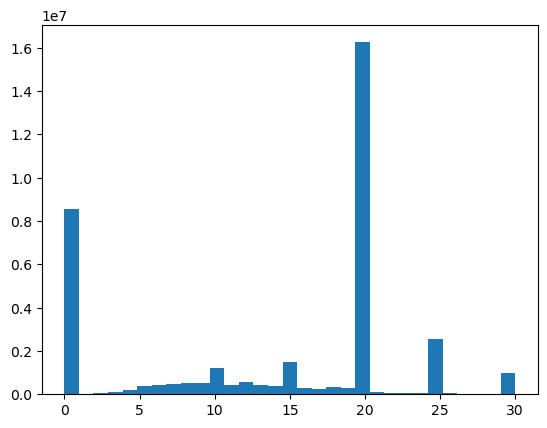

In [14]:
plt.hist(y_2023.tip_pct, bins = 31, range = (0, 30))
plt.show()

Looking at a histogram of tip percentages, we see a clear delineation at 5% increments, which we expect from a suggested tip option for e-payment.

Next: add speed and $ / min features. S / min is our KPI for measuring profitability, determined by (fare + tip - gas) / time, where the price of gas is based on an average NYC price of $3.50 / gallon.

In [15]:
y_2023['speed'] = (60 * y_2023.trip_distance / y_2023.duration).round(2)
y_2023['dollar_min'] = ((y_2023.fare_amount + y_2023.tip_amount - 0.15 * y_2023.trip_distance) / y_2023.duration).round(2)

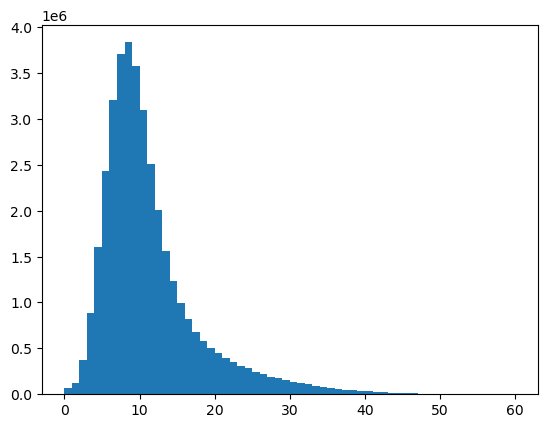

In [16]:
plt.hist(y_2023.speed, bins = 60, range = (0, 60))
plt.show()

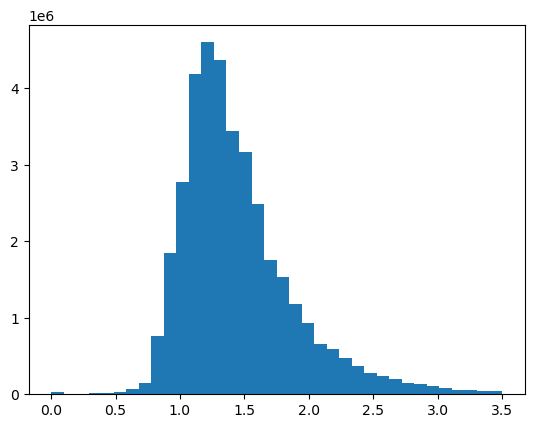

In [17]:
plt.hist(y_2023.dollar_min, bins = 36, range = (0, 3.5))
plt.show()

Distribution of speed and dollars per minute follow a left-skewed distribution, with dollars per minute highly correlated with speed.

Remove bad data:
- trips with unknown pickup or dropoff locations (designated as zones 264 and 265)
- 0 and negative fares
- trips with duration less than 1 minute or over 6 hours
- trips with speed > 60 mph
- negative tips

In [18]:
bad_loc = (y_2023.PULocationID > 263) | (y_2023.DOLocationID > 263)
y_2023 = y_2023.drop(y_2023[bad_loc].index)
gc.collect()

: 

In [ ]:
bad_fare = (y_2023.fare_amount <= 0) | (y_2023.total_amount <= 0)
y_2023 = y_2023.drop(y_2023[bad_fare].index)
gc.collect()

In [ ]:
bad_time = (y_2023.duration < 1) | (y_2023.duration > 360)
y_2023 = y_2023.drop([bad_time].index)
gc.collect()

In [ ]:
bad_speed = (y_2023.speed > 60)
y_2023 = y_2023.drop([bad_speed].index)
gc.collect()

In [ ]:
bad_tip = (y_2023.tip_amount < 0)
y_2023 = y_2023.drop([bad_tip].index)
gc.collect